# Programming Exercise


In [ ]:
import torch
from load_mnist import load_mnist

In [ ]:
X_train, y_train = load_mnist(dataset='training', path='data')
X_test, y_test = load_mnist(dataset='testing', path='data')

## kNN Classifier implementation

In [ ]:
# a.1)
class KNNClassifier:
    def __init__(self, k: int, X_train: torch.Tensor, y_train: torch.Tensor):
        self.k = k
        self.X_train = torch.reshape(X_train, (-1, 784))
        self.y_train = y_train
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = torch.reshape(X, (-1, 784)) # .flatten(1)
        dist = torch.cdist(X, self.X_train)
        nearest_k_idx = torch.topk(dist, k=self.k, largest=False).indices
        
        # .mode to get mode(most frequent) of the nearest indices
        # return torch.mode(self.y_train[nearest_k_idx], dim=0).values 
        
        labels = list(map(self.get_majority, nearest_k_idx))
        return torch.Tensor(labels).to(dtype=torch.int8)

    def get_majority(self, train_indices: torch.Tensor) -> int:
        """
            For given indices from training set, find their labels and find the majority
        """
        values = torch.index_select(self.y_train, 0, train_indices)
        majority = int(values.mode().values.item())
        return majority
    
    def accuracy(self, x_test: torch.Tensor, y_test: torch.Tensor):
        result = self.forward(x_test)
        # .eq 
        acc = torch.count_nonzero(result == y_test) / y_test.size()[0]
        return acc

In [ ]:
# a.2)
# Creating balanced subset of the training data

import numpy as np

X_train_subset = []
Y_train_subset = []

# indices = torch.argsort(labels)
# grouped_images = images[indices]
for i in range(10):  # for each class 
    # torch.randperm() 
    label_idx = torch.nonzero(y_train == i).reshape(-1).numpy()
    lbl_idx_subset = np.random.choice(label_idx, 100, replace=False)
    X_train_subset.extend([X_train[j] for j in lbl_idx_subset])
    Y_train_subset.extend([i] * 100)

X_train_subset = torch.cat(X_train_subset).reshape(-1, 28, 28)
# torch .arange .repeat_interleave
Y_train_subset = torch.tensor(Y_train_subset)

In [ ]:
# a.2)
# Calculating the accuracy with different values for k

knn_1 = KNNClassifier(1, X_train_subset, Y_train_subset)
knn_5 = KNNClassifier(5, X_train_subset, Y_train_subset)

for knn in [knn_1, knn_5]:
    acc = knn.accuracy(X_test, y_test)
    print(f'Accuracy with k = {knn.k} is {acc:.4f}')

Accuracy with k = 1 is 0.7540
Accuracy with k = 5 is 0.7575


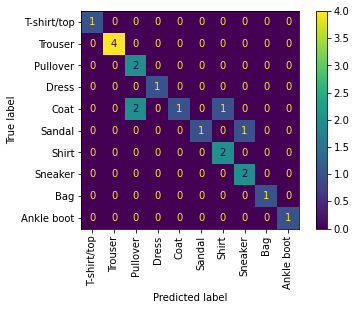

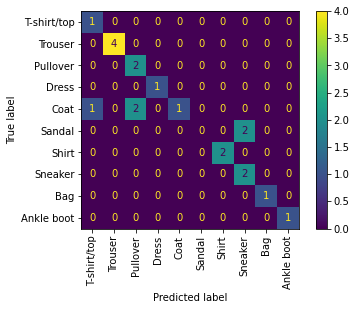

In [ ]:
# a.2)
# Visualization of confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
for knn in [knn_1, knn_5]:
    results = knn.forward(X_test[:20])
    conf_mat = confusion_matrix(y_test[:20].tolist(), results.tolist())
    ConfusionMatrixDisplay(conf_mat, display_labels=labels).plot(xticks_rotation='vertical')

In [ ]:
# a.2)
# 5-fold cross-validation

from sklearn.model_selection import KFold

# used arrays instead of function

def five_fold_cv(k: int, x_train: torch.Tensor, y_train: torch.Tensor):
    acc = 0
    kf = KFold(n_splits=5, shuffle=True)
    for train_idx, val_idx in kf.split(x_train):
        train_idx = torch.from_numpy(train_idx)
        val_idx = torch.from_numpy(val_idx)
        x_train_subset = x_train.index_select(0, train_idx)
        y_train_subset = y_train.index_select(0, train_idx)
        x_val_subset = x_train.index_select(0, val_idx)
        y_val_subset = y_train.index_select(0, val_idx)
        knn = KNNClassifier(k, x_train_subset, y_train_subset)
        acc += knn.accuracy(x_val_subset, y_val_subset)
    return acc / 5

In [ ]:
# a.2) Calculate accuracies from cross-validation step
accuracies = []
k_list = list(range(1, 16))
for k in k_list:
    acc = five_fold_cv(k, X_train_subset, Y_train_subset)
    accuracies.append(acc)

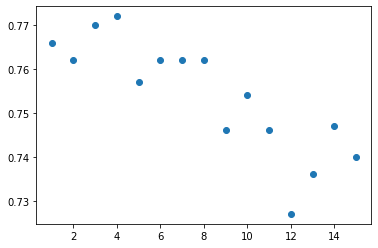

In [ ]:
# a.2) Visualize the accuracies
plt.scatter(k_list, accuracies)
plt.show()

From the plot we can see that $k=3$ has best accuracy when performing 5-fold cross-validation

## b) Dataloading and Preprocessing

In [ ]:
from torchvision import transforms

class FashionDataset(torch.utils.data.Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        zero_or_one_idx = torch.nonzero((y==1).add((y==0))).reshape(-1)
        self.X = X.index_select(0, zero_or_one_idx)
        self.y = y.index_select(0, zero_or_one_idx)
        self.transform = transforms.Compose([
            transforms.Normalize(X.mean(), X.std())
        ])

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        x = self.transform(x.unsqueeze(0))
        return x.squeeze(), y

    def __len__(self):
        return self.y.size()[0]

In [ ]:
fashion_dataset = FashionDataset(X_train, y_train)
fashion_test = FashionDataset(X_test, y_test)
dataloader_train = torch.utils.data.DataLoader(fashion_dataset, batch_size=32, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(fashion_test, batch_size=32, shuffle=True)

## c)  Linear  Classifier  with  Logistic  Function

In [ ]:
class Network(torch.nn.Module):
    def __init__(self, in_f, out_f):
        super(Network, self).__init__()
        self.fc1 = torch.nn.Linear(in_f, out_f)

    def forward(self, x: torch.Tensor):
        x = x.view(-1, 784)
        return torch.sigmoid(self.fc1(x))

In [ ]:
class FashionTrainer:
    def __init__(self, model: Network, train_dataloader: torch.utils.data.DataLoader, test_dataloader: torch.utils.data.DataLoader):
        self.criterion = torch.nn.CrossEntropyLoss()
        self.model = model
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=0.005, momentum=0.9)
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader

    def train(self):
        running_loss = 0.0
        total_loss = 0.0
        for i, (input_data, labels) in enumerate(self.train_dataloader):
            self.optimizer.zero_grad()
            predictions = self.model(input_data.float())
            loss = self.criterion(predictions, labels.long())
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()
            total_loss += loss.item()
            if i % 100 == 99:
                print("Batch: [%3d] Loss: %.3f" % (i+1, running_loss/100))
                running_loss = 0.0
        return total_loss / len(self.train_dataloader)
    
    def test(self):
        acc = 0
        for input_data, labels in trainer.test_dataloader:
            predictions = trainer.model(input_data)
            acc += torch.count_nonzero(torch.argmax(predictions, dim=1) == labels) / len(labels)
        acc /= len(trainer.test_dataloader)
        return acc


In [ ]:
model = Network(784, 10)
trainer = FashionTrainer(model, dataloader_train, dataloader_test)
epochs = 25
losses = []
for i in range(epochs):
    print(f"\nEpoch: {i+1}")
    loss = trainer.train()
    losses.append(loss)


Epoch: 1
Batch: [100] Loss: 1.645
Batch: [200] Loss: 1.561
Batch: [300] Loss: 1.554

Epoch: 2
Batch: [100] Loss: 1.545
Batch: [200] Loss: 1.543
Batch: [300] Loss: 1.542

Epoch: 3
Batch: [100] Loss: 1.542
Batch: [200] Loss: 1.542
Batch: [300] Loss: 1.541

Epoch: 4
Batch: [100] Loss: 1.541
Batch: [200] Loss: 1.538
Batch: [300] Loss: 1.538

Epoch: 5
Batch: [100] Loss: 1.538
Batch: [200] Loss: 1.539
Batch: [300] Loss: 1.537

Epoch: 6
Batch: [100] Loss: 1.539
Batch: [200] Loss: 1.539
Batch: [300] Loss: 1.536

Epoch: 7
Batch: [100] Loss: 1.537
Batch: [200] Loss: 1.538
Batch: [300] Loss: 1.539

Epoch: 8
Batch: [100] Loss: 1.538
Batch: [200] Loss: 1.538
Batch: [300] Loss: 1.537

Epoch: 9
Batch: [100] Loss: 1.538
Batch: [200] Loss: 1.538
Batch: [300] Loss: 1.536

Epoch: 10
Batch: [100] Loss: 1.538
Batch: [200] Loss: 1.536
Batch: [300] Loss: 1.536

Epoch: 11
Batch: [100] Loss: 1.536
Batch: [200] Loss: 1.538
Batch: [300] Loss: 1.535

Epoch: 12
Batch: [100] Loss: 1.536
Batch: [200] Loss: 1.534
Ba

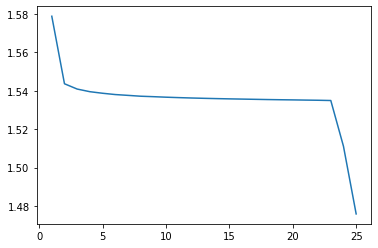

In [ ]:
plt.plot(list(range(1, epochs+1)), losses)
plt.show()

In [ ]:
acc = trainer.test()
f'The accurracy of the model on the test set for labels 0 and 1 is {acc:.4f}'

'The accurracy of the model on the test set for labels 0 and 1 is 0.9777'